In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from qiskit import *
from qiskit.tools.monitor import job_monitor

import numpy as np
from qaoa_OOP import *
from exactcover import *
from tailassignment_oop import * 
from tailassignment_loader import * 
from plots import *

import os

import sys
sys.path.append('../')

from qiskit_utilities.utilities import *

from qiskit.visualization import plot_histogram

In [3]:
from matplotlib import rc
import matplotlib.pyplot as plt
import matplotlib as mpl
# from tqdm import tqdm

fontsize = 24
newparams = {'axes.titlesize': fontsize,
             'axes.labelsize': fontsize,
             'ytick.labelsize': fontsize,
             'xtick.labelsize': fontsize, 
             'legend.fontsize': fontsize,
             'figure.titlesize': fontsize,
             'legend.handlelength': 1.5, 
             'lines.linewidth': 2,
             'lines.markersize': 7,
             'figure.figsize': (12, 7), 
             'figure.dpi':200,
             'text.usetex' : False,
             'font.family' : "sans-serif"
            }

plt.rcParams.update(newparams)

In [ ]:
def averageQAOA(qaoa_type, options, simulation_args, num_route, num_sols, num_arr):
    flights = 24
    max_depth = simulation_args.get('max_depth',10)
    SP_all = np.zeros((len(num_sols), max_depth))
    C_all = np.zeros_like(SP_all)
    SP_avg = np.zeros(max_depth)
    C_avg = np.zeros_like(SP_avg)
    per_cent_best_cost = np.zeros((len(num_sols), max_depth))
    for i in range(len(num_sols)):
        print()
        print('Now using', num_sols[i], 'solutions, set number', num_arr[i])
        FR,CR = load_giorgio(f'./data/tail_assignment/Our_routes/Giorgio_routes_cost/FRCR_{num_route}_{flights}_{num_sols[i]}_{num_arr[i]}.npy')
        CR /= np.amax(CR)
        mu = np.amax(CR)
        options['FR'] = FR
        options['CR'] = CR
        options['mu'] = mu

        qaoa = qaoa_type(options)
        Elandscape, gammabetas, E, best = qaoa.simulate(**simulation_args)
        SP, C = qaoa.simulation_statistics(plot = False)
        best_cost = np.max( qaoa.vector_cost(qaoa.state_strings) )
        optimal_solution = qaoa.best_cost_string()
        state_strings = qaoa.state_strings 
        for k in range(1,max_depth+1):
            qaoa.depth = k
            circuit = qaoa.createCircuit(qaoa.params['xL_d' +str(k)])
            if qaoa.backend.configuration().local:
                job = execute(circuit, backend = qaoa.backend, noise_model = qaoa.noise_model, shots = qaoa.shots)
            else:
                job = start_or_retrieve_job(name +"_"+str(g_it), qaoa.backend, circuit, options = {'shots' : qaoa.shots})
            optimal_ind = np.where(state_strings==optimal_solution)
            per_cent_best_cost[i, k-1] = (np.abs(job.result().get_statevector())**2)[optimal_ind]


        SP_all[i] = SP
        print(-best_cost, -C)
        C_all[i] = C/best_cost
        SP_avg += SP/len(num_sols)
        C_avg += C/(len(num_sols)*best_cost)
        print(C_all, C_avg)
        print(SP_all, SP_avg)
    return SP_avg, SP_all, C_avg, C_all, per_cent_best_cost


In [4]:
num_routes = 7

options={}
options['usebarrier'] = True



beta_n    = 60
gamma_n   = 100

beta_max  = np.pi
gamma_max = 2 * np.pi

optmethod = 'Nelder-Mead'
shots     = 1024 # no need for more shots when using the statevector simulation
rerun     = True
max_depth = 30

In [5]:
Aer.backends()
backend = Aer.get_backend('statevector_simulator')

In [6]:
simulation_args = dict()

simulation_args['backend']   = backend
simulation_args['optmethod'] = optmethod
simulation_args['max_depth'] = max_depth
simulation_args['repeats']   = 1
simulation_args['params_ll'] = np.array([0,0])
simulation_args['params_ul'] = np.array([gamma_max,beta_max])
simulation_args['params_n']  = np.array([gamma_n, beta_n])
simulation_args['shots']     = shots


In [7]:
options

{'usebarrier': True}

In [8]:
simulation_args

{'backend': StatevectorSimulator('statevector_simulator'),
 'optmethod': 'Nelder-Mead',
 'max_depth': 30,
 'repeats': 1,
 'params_ll': array([0, 0]),
 'params_ul': array([6.28318531, 3.14159265]),
 'params_n': array([100,  60]),
 'shots': 1024}

In [9]:
sol_arr = np.array([3,3,3,3,3,3,4,4,4,4])
num_arr = np.array([1,2,3,5,6,4,1,2,3,4])

SP_avg, SP, C_avg, C, best_cost_overlap= averageQAOA(QAOATailAssignment,options, simulation_args, num_routes, sol_arr, num_arr)


Now using 3 solutions, set number 1
Calculating energy landscape ...
Optimization terminated successfully.
         Current function value: 9.492244
         Iterations: 25
         Function evaluations: 49
Calculating energy landscape done.
Depth = 1, Rep = 1
Optimization terminated successfully.
         Current function value: 9.492244
         Iterations: 10
         Function evaluations: 21
P = [3.06425867 0.85879717]
P_ = [3.06425867 0.85879717 3.06425867 0.85879717]
Depth = 2, Rep = 1
Optimization terminated successfully.
         Current function value: 8.591419
         Iterations: 86
         Function evaluations: 142
P = [3.2160068  1.28764719 3.11598436 0.54501049]
P_ = [3.2160068  1.28764719 3.16599558 0.91632884 3.11598436 0.54501049]
Depth = 3, Rep = 1
Optimization terminated successfully.
         Current function value: 6.515668
         Iterations: 123
         Function evaluations: 215
P = [3.19673597 1.03790096 3.08661874 0.9640635  3.01837595 0.52424973]
P_ = [3.1

Optimization terminated successfully.
         Current function value: 4.930007
         Iterations: 2218
         Function evaluations: 2758
P = [3.27001925 0.71862724 3.33601498 1.02554782 3.27022476 0.76109618
 3.28439397 0.83422479 3.24802009 0.70479413 3.24786324 0.69074847
 3.28482815 0.89790234 3.23405586 0.58786182 3.22968963 0.63681006
 3.24239135 0.50739201 3.23422991 0.38296921 3.25848976 0.28556423
 3.2843526  0.1852213  3.18478072 0.28573455 3.32228407 0.81209163
 3.15023957 0.76554696]
P_ = [3.27001925 0.71862724 3.33189025 1.00636528 3.27844854 0.79415263
 3.28173725 0.82051318 3.25711356 0.73715179 3.24791225 0.69513774
 3.27096631 0.82021964 3.25626874 0.72350454 3.23187274 0.61233594
 3.23524663 0.58018966 3.23933081 0.46073346 3.24181111 0.35253015
 3.26495547 0.2604785  3.26568287 0.20406753 3.20196864 0.35152919
 3.31153129 0.80918259 3.15023957 0.76554696]
Depth = 17, Rep = 1
Optimization terminated successfully.
         Current function value: 3.143985
         

Optimization terminated successfully.
         Current function value: 2.856653
         Iterations: 3098
         Function evaluations: 3692
P = [3.13466472 0.87969291 3.17691398 1.43833239 3.23477189 0.98366895
 3.27509868 1.20422808 3.20063043 0.70231888 3.25875592 0.7352557
 3.24026297 0.76922731 3.23489783 0.66505564 3.24708813 0.65655728
 3.22321035 0.84595123 3.20521109 0.52382892 3.2325367  0.68141418
 3.20412388 0.65203004 3.21434863 0.61985999 3.25020138 0.54470716
 3.21061944 0.44772244 3.25389565 0.32409372 3.20140371 0.29757744
 3.21832919 0.2594473  3.34041252 0.25477848 3.1396864  0.32074057
 3.20694383 0.49077628 3.12905944 0.69691271 3.13786138 0.4016483 ]
P_ = [3.13466472 0.87969291 3.17515359 1.41505574 3.2299504  1.02155757
 3.27005783 1.17665819 3.2130418  0.78597041 3.24664645 0.72839386
 3.2448862  0.76073441 3.23646266 0.69543904 3.24302469 0.65939007
 3.23216451 0.7749285  3.21271078 0.65804655 3.22001246 0.6091876
 3.21833029 0.66672211 3.20881022 0.63728544 3

Optimization terminated successfully.
         Current function value: 4.733793
         Iterations: 3079
         Function evaluations: 3677
1.4444444444444444 [9.49224379 8.5914185  6.51566825 7.92243428 6.42528895 5.88013642
 6.44212283 5.43794686 5.42021124 5.34998253 3.67544153 3.97707443
 5.37860701 3.82654632 5.28887474 4.93000708 3.14398468 3.15443261
 3.68304584 2.49066897 3.23659373 2.65107815 2.96058249 2.85665338
 3.26212317 3.22077985 2.81093423 2.96437621 3.89284757 4.73379294]
[[6.57155339 5.94790512 4.51084725 5.48476219 4.44827696 4.07086367
  4.45993119 3.76473244 3.75245393 3.70383406 2.54453644 2.75335922
  3.72365101 2.64914745 3.66152866 3.41308183 2.17660478 2.18383796
  2.54980097 1.72430929 2.24071873 1.8353618  2.04963403 1.97768311
  2.25839296 2.22977067 1.94603139 2.05226045 2.69504832 3.27724127]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.     

Optimization terminated successfully.
         Current function value: 3.780437
         Iterations: 168
         Function evaluations: 258
P = [0.05288565 2.11425996 0.13062444 1.87485044 0.12599333 1.82095433
 0.21031196 1.78829467]
P_ = [0.05288565 2.11425996 0.11118974 1.93470282 0.12830888 1.84790239
 0.14707299 1.81278942 0.21031196 1.78829467]
Depth = 5, Rep = 1
Optimization terminated successfully.
         Current function value: 3.036865
         Iterations: 319
         Function evaluations: 447
P = [0.09547631 1.89876613 0.03543993 1.85769985 0.20246084 1.78708054
 0.05424027 1.74892824 0.2533223  1.74949832]
P_ = [0.09547631 1.89876613 0.04744721 1.86591311 0.13565248 1.81532827
 0.14317261 1.77181962 0.09405667 1.74904225 0.2533223  1.74949832]
Depth = 6, Rep = 1
Optimization terminated successfully.
         Current function value: 3.008015
         Iterations: 656
         Function evaluations: 907
P = [-0.04344237  2.7200324   0.09311632  1.99630131 -0.01756695  1.5586

P = [ 6.92362848e-03  1.14398868e+00  2.79501604e-02  3.80972187e+00
  1.70495385e-02  9.38572769e-01 -2.99438741e-04  7.12546996e-01
 -3.35575485e-05  2.54151714e-02 -1.09777656e-03 -1.23539556e+00
  4.84888424e-03  3.41097469e+00  3.14473827e-02  3.67083790e+00
  8.72750147e-02  3.54396494e+00  1.33530188e-01  1.78845581e+00
  7.89981857e-02  1.77104295e+00  2.18872437e-01  1.41058830e+00
 -3.30632321e-02  2.01121757e+00  2.19113713e-01  1.61201683e+00
  4.41955527e-02  1.75164757e+00  2.93563571e-01  1.68199777e+00]
P_ = [ 6.92362848e-03  1.14398868e+00  2.66360022e-02  3.64311354e+00
  1.84121163e-02  1.29746641e+00  2.95349449e-03  7.54926828e-01
 -1.00027847e-04  1.97198127e-01 -7.65208117e-04 -8.41392208e-01
  2.61888644e-03  1.66858584e+00  1.98105396e-02  3.55714774e+00
  5.93611987e-02  3.60740142e+00  1.07511653e-01  2.77592970e+00
  1.13080687e-01  1.78192598e+00  1.22708889e-01  1.65840087e+00
  1.55888520e-01  1.56074562e+00  1.42199451e-02  1.93636743e+00
  1.97248943e-0

Optimization terminated successfully.
         Current function value: 1.704664
         Iterations: 7440
         Function evaluations: 8646
P = [-1.27916037e-02  5.26733752e-01  1.20536740e-02  4.66079991e+00
  1.00050755e-02  3.81496699e+00 -2.82736499e-02  1.41691017e+00
 -1.46618008e-03  2.41612401e+00  1.25971449e-03  9.93973175e-01
  5.04905968e-04  4.14294961e-01  3.72039585e-05  1.13154232e+00
 -2.86693542e-03  9.53508773e-01  2.48761872e-02  2.04020555e+00
  1.08724216e-01  3.47061844e+00  4.47949652e-02  4.69088300e+00
  5.12804381e-02  2.76338567e+00  1.76303523e-02  2.25209538e+00
  1.31241732e-01  1.74454364e+00  8.42661905e-02  1.79796006e+00
  1.88766253e-01  1.80181688e+00  5.39874285e-02  1.62319386e+00
  2.08198816e-01  1.85521489e+00  1.65433677e-02  1.52573243e+00
  2.43218999e-01  1.69169254e+00  1.12982675e-01  1.65269843e+00
  2.64881907e-01  1.66044298e+00]
P_ = [-1.27916037e-02  5.26733752e-01  1.09734446e-02  4.48105790e+00
  1.01832145e-02  3.88851768e+00 -2

P = [-4.05394788e-02  9.22854916e-02  3.48897494e-03  3.14446991e+00
  2.14410517e-03  1.75011104e+00 -1.92933898e-02  7.65677229e-01
 -7.41810430e-02  1.30739735e+00 -2.11413476e-02  1.25360446e+00
 -1.98924269e-03  1.76174466e+00  1.48472147e-04  1.29955384e+00
  2.46789038e-04  1.33634333e+00  9.14618643e-03  3.09642131e+00
  1.48393256e-02  1.88862637e+00  3.83337996e-03  1.04584608e+00
  1.16238422e-05  3.86787210e+00  1.34356739e-02  3.57326866e+00
  3.20883772e-02  3.06748933e+00  2.82893490e-02  4.22526417e+00
  5.37600855e-02  3.60174837e+00  6.30264348e-02  3.34672945e+00
  8.29294741e-02  1.86322938e+00  1.38453965e-01  1.76054026e+00
  8.98045426e-02  1.81509390e+00  1.78168298e-01  1.73620703e+00
  6.42231345e-02  1.72176420e+00  2.06307999e-01  1.72417298e+00
  3.22820725e-02  1.67416092e+00  2.40335673e-01  1.69531557e+00
  8.91888582e-02  1.66246445e+00  2.64733352e-01  1.66582757e+00]
P_ = [-4.05394788e-02  9.22854916e-02  1.91653016e-03  3.03546332e+00
  2.24016729e-0

Optimization terminated successfully.
         Current function value: 7.704162
         Iterations: 30
         Function evaluations: 56
Calculating energy landscape done.
Depth = 1, Rep = 1
Optimization terminated successfully.
         Current function value: 7.704162
         Iterations: 6
         Function evaluations: 13
P = [0.15260248 2.02589483]
P_ = [0.15260248 2.02589483 0.15260248 2.02589483]
Depth = 2, Rep = 1
Optimization terminated successfully.
         Current function value: 6.397471
         Iterations: 98
         Function evaluations: 160
P = [-0.11129321  2.10647611  0.07310716  2.13027992]
P_ = [-0.11129321  2.10647611 -0.01909303  2.11837801  0.07310716  2.13027992]
Depth = 3, Rep = 1
Optimization terminated successfully.
         Current function value: 5.452193
         Iterations: 89
         Function evaluations: 147
P = [ 0.13477173  3.0169489  -0.03127744  0.56944008  0.15647523  1.82257701]
P_ = [0.13477173 3.0169489  0.02407228 1.38527635 0.03130678 0.98

Optimization terminated successfully.
         Current function value: 1.867141
         Iterations: 1573
         Function evaluations: 1916
P = [-0.03451412  2.42095    -0.01962205  2.59804403  0.05622697  0.77520268
  0.13598588  0.58319477  0.16841185  0.4838587   0.1836264   0.41711945
  0.21033713  0.36200808  0.21324797  0.31091108  0.22214115  0.27726866
  0.24780904  0.24759211  0.23090912  0.18489114  0.24217022  0.17084863
  0.29518183  0.16840128  0.3087237   0.11241434  0.31968711  1.63462866]
P_ = [-0.03451412  2.42095    -0.02061485  2.58623776  0.04611377  1.0182482
  0.1200341   0.62159636  0.15976492  0.51034832  0.17855488  0.43936587
  0.19965284  0.38405263  0.21188958  0.33475634  0.21739812  0.29521128
  0.2324083   0.26539804  0.24217574  0.22669178  0.23391208  0.18114647
  0.25277254  0.17035916  0.29698741  0.16093635  0.3094546   0.21389529
  0.31968711  1.63462866]
Depth = 16, Rep = 1
Optimization terminated successfully.
         Current function value: 1.

Optimization terminated successfully.
         Current function value: 1.598394
         Iterations: 1465
         Function evaluations: 1784
P = [-0.02000621  2.44560874 -0.01784025  3.40429038  0.04034439  0.82029471
  0.07052689  0.82557495  0.10936863  0.63168034  0.14547781  0.51719456
  0.17739072  0.48024893  0.20260839  0.45044984  0.21350651  0.40565543
  0.22487785  0.39306146  0.22549623  0.34085839  0.21692672  0.34258676
  0.21817981  0.36260049  0.23270822  0.33571342  0.23382156  0.2993497
  0.23052597  0.27182952  0.23512792  0.23331897  0.24260702  0.27073483
  0.29124441  0.22340082  0.3555559   0.22539837  0.35923015  0.13343106
  0.3302897   0.12659439  0.44406317  1.64326214]
P_ = [-0.02000621  2.44560874 -0.01793442  3.36260857  0.03528486  1.04498998
  0.06659005  0.82488622  0.10261355  0.66540114  0.13762799  0.54208278
  0.16906561  0.48988692  0.19493345  0.45951913  0.20971586  0.4212361
  0.2204282   0.39798953  0.22522737  0.36355538  0.22102518  0.3417601

Optimization terminated successfully.
         Current function value: 1.587723
         Iterations: 1419
         Function evaluations: 1702
P = [-0.02885553  1.80817009 -0.03049418  3.2018107   0.02515452  1.51365906
  0.04614088  1.08643008  0.07605223  0.82137559  0.11502419  0.65738081
  0.14142941  0.56242516  0.16043238  0.52008539  0.17719521  0.4772555
  0.1896834   0.43680861  0.20061797  0.41770539  0.22309712  0.41138228
  0.22745693  0.39049764  0.22566858  0.35500765  0.22829773  0.34954733
  0.23408263  0.3343646   0.22968824  0.35147772  0.2251037   0.33338101
  0.22369287  0.32080797  0.2264321   0.29970441  0.22382903  0.25433176
  0.22341417  0.26534217  0.27028096  0.28240796  0.31458229  0.29396625
  0.3378527   0.23560899  0.3631095   0.20214883  0.37926158  0.17011469
  0.34178245  0.12358539  0.37783878  1.64532461]
P_ = [-0.02885553  1.80817009 -0.03043768  3.15375413  0.02131668  1.63008331
  0.04396988  1.13062618  0.07192653  0.85793483  0.10830489  0.685655

Optimization terminated successfully.
         Current function value: 11.451335
         Iterations: 27
         Function evaluations: 55
Calculating energy landscape done.
Depth = 1, Rep = 1
Optimization terminated successfully.
         Current function value: 11.451335
         Iterations: 11
         Function evaluations: 25
P = [3.08521663 2.30087987]
P_ = [3.08521663 2.30087987 3.08521663 2.30087987]
Depth = 2, Rep = 1
Optimization terminated successfully.
         Current function value: 9.806289
         Iterations: 45
         Function evaluations: 86
P = [2.91190868 2.46597684 3.32287769 2.13831951]
P_ = [2.91190868 2.46597684 3.11739318 2.30214817 3.32287769 2.13831951]
Depth = 3, Rep = 1
Optimization terminated successfully.
         Current function value: 10.533044
         Iterations: 136
         Function evaluations: 225
P = [2.90001774 2.41624234 3.10724819 1.62572087 3.44990154 2.35699585]
P_ = [2.90001774 2.41624234 3.03817137 1.88922803 3.22146597 1.8694792
 3.449

Optimization terminated successfully.
         Current function value: 7.391752
         Iterations: 755
         Function evaluations: 1035
P = [2.86315177 2.76698977 3.16494429 2.31049765 3.05251482 2.21901016
 3.2435565  2.14565012 3.16732396 2.12878332 3.20665824 2.01386429
 3.33499753 1.85882518 3.37669425 1.75146928 3.61871801 1.852192
 3.57701    1.88768308 3.3714069  1.75657008 3.34084947 2.13647229
 3.22046371 2.25210266 3.29054018 2.14345093 3.34944257 2.45543771
 3.28989072 2.80567541]
P_ = [2.86315177 2.76698977 3.14608226 2.33902841 3.0665685  2.2304461
 3.20773619 2.15940513 3.18638209 2.13300002 3.19436628 2.04977649
 3.2868703  1.91696485 3.35845193 1.79843749 3.49770613 1.80183064
 3.60047076 1.86771935 3.49990883 1.83851571 3.3618577  1.87528952
 3.31075303 2.16537988 3.23360305 2.23173046 3.29790298 2.18244928
 3.34572058 2.47732756 3.28989072 2.80567541]
Depth = 17, Rep = 1
Optimization terminated successfully.
         Current function value: 6.689906
         Iter

Optimization terminated successfully.
         Current function value: 4.773331
         Iterations: 1322
         Function evaluations: 1712
P = [2.85930721 2.78233896 3.19686648 2.62878036 3.09425629 2.60425848
 3.18036822 2.21592138 3.27782728 2.1291664  3.28011116 2.05765475
 3.3041212  1.91145662 3.17047985 1.80356732 3.1962741  1.88555818
 3.20893563 1.86842739 3.23454514 1.84532243 3.4284466  1.85564686
 3.49778911 2.0177097  3.53674575 2.0156324  3.40825994 1.95604346
 3.46715356 2.01516087 3.44223838 1.97961324 3.35928668 1.91561898
 3.35208543 2.07081292 3.3443867  2.36439119 3.4322762  2.4286787
 3.39197137 2.61849402 3.32809799 2.57826187 3.3407432  2.86955188]
P_ = [2.85930721 2.78233896 3.18280151 2.63517863 3.10280714 2.60630197
 3.16960423 2.26446352 3.2615841  2.14362557 3.27963535 2.07255301
 3.29811869 1.94800616 3.20945857 1.83503503 3.18767601 1.85822789
 3.20418756 1.87485144 3.22387452 1.8549495  3.3395751  1.85091483
 3.46311785 1.93667828 3.51564424 2.0167576  

Optimization terminated successfully.
         Current function value: 3.568228
         Iterations: 3032
         Function evaluations: 3690
2.2857142857142856 [11.45133476  9.80628903 10.53304391  8.76321997  8.91081807 12.18555498
  8.13471592  7.77501089  9.34973755  9.52071308  8.84273883  6.26376956
  5.42292081  4.79520442  5.63158373  7.3917518   6.68990559  5.17192061
  5.08571674  3.94954343  4.55637716  4.88039903  5.85028149  4.77333057
  5.26615174  5.65153396  4.78701302  4.59624046  5.15332304  3.56822798]
[[6.57155339 5.94790512 4.51084725 5.48476219 4.44827696 4.07086367
  4.45993119 3.76473244 3.75245393 3.70383406 2.54453644 2.75335922
  3.72365101 2.64914745 3.66152866 3.41308183 2.17660478 2.18383796
  2.54980097 1.72430929 2.24071873 1.8353618  2.04963403 1.97768311
  2.25839296 2.22977067 1.94603139 2.05226045 2.69504832 3.27724127]
 [7.58106801 6.81608452 4.28714233 4.07123972 3.27046962 3.23940109
  3.69518164 3.2411352  2.8435791  2.91039551 2.52147765 2.71183

Optimization terminated successfully.
         Current function value: 6.296254
         Iterations: 135
         Function evaluations: 200
P = [0.0912175  1.88244575 0.05611754 1.74218153 0.1903651  1.81563093]
P_ = [0.0912175  1.88244575 0.06781753 1.78893627 0.10086673 1.76666467
 0.1903651  1.81563093]
Depth = 4, Rep = 1
Optimization terminated successfully.
         Current function value: 6.226025
         Iterations: 158
         Function evaluations: 241
P = [0.03185976 2.10869391 0.10465552 1.86913619 0.08555688 1.75484448
 0.17507612 1.78711209]
P_ = [0.03185976 2.10869391 0.08645658 1.92902562 0.0951062  1.81199033
 0.10793669 1.76291138 0.17507612 1.78711209]
Depth = 5, Rep = 1
Optimization terminated successfully.
         Current function value: 4.659312
         Iterations: 581
         Function evaluations: 826
P = [ 0.07343328  0.91292824 -0.02334356  2.75546042  0.19783753  1.61856624
  0.01950003  1.8182347   0.20716979  1.77268648]
P_ = [ 0.07343328  0.91292824 -0.0

Optimization terminated successfully.
         Current function value: 3.163860
         Iterations: 1116
         Function evaluations: 1444
P = [0.02031851 0.50923353 0.01446723 3.22185389 0.03242274 3.52256504
 0.06728002 3.44400061 0.07891395 3.39487365 0.10363333 3.37560305
 0.11779757 3.34678994 0.12580998 3.31816973 0.13642641 3.27723492
 0.12283926 3.25201562 0.10018242 3.12162139 0.06567412 3.2941579
 0.03661449 3.01764675 0.02884298 1.64429256 0.07779053 1.59133703
 0.17292826 1.60787038]
P_ = [0.02031851 0.50923353 0.01483294 3.05231512 0.0301783  3.48497615
 0.06074428 3.45873144 0.07600547 3.40715539 0.09590852 3.38162511
 0.11248598 3.35759486 0.12230455 3.33069107 0.13111819 3.29770233
 0.13048203 3.26620148 0.11434294 3.20311779 0.08939858 3.17553905
 0.05840921 3.22503011 0.03515733 2.76014284 0.03496142 1.63767312
 0.08373664 1.59237036 0.17292826 1.60787038]
Depth = 17, Rep = 1
Optimization terminated successfully.
         Current function value: 3.046467
         I

Optimization terminated successfully.
         Current function value: 2.936130
         Iterations: 708
         Function evaluations: 979
P = [0.01591366 0.5779946  0.0144981  3.43427423 0.02199642 3.47322502
 0.03247703 3.50932877 0.05018317 3.41646336 0.06701577 3.42480253
 0.08303467 3.378972   0.09635573 3.3746724  0.10674342 3.35386755
 0.11433448 3.32346593 0.11875256 3.29868394 0.12396727 3.27549491
 0.126072   3.27442211 0.1281345  3.23587139 0.12603891 3.2211364
 0.11087847 3.21256503 0.08982615 3.14646883 0.07587293 3.15173672
 0.05175009 3.19822642 0.04042319 3.31390701 0.03233081 2.81828938
 0.03699585 1.72820038 0.05892064 1.60744331 0.16657364 1.60570292]
P_ = [0.01591366 0.5779946  0.01455708 3.31526258 0.02137156 3.46997912
 0.03116695 3.5048158  0.04723215 3.43194093 0.06350898 3.42306521
 0.07902994 3.39042963 0.09247042 3.37592645 0.10328085 3.3608025
 0.11148783 3.33486654 0.11691169 3.30900977 0.12157719 3.28612321
 0.12501964 3.27495851 0.12701731 3.25675303 0.1

Optimization terminated successfully.
         Current function value: 2.891599
         Iterations: 832
         Function evaluations: 1181
2.4285714285714284 [9.71662794 9.09551952 6.29625365 6.22602508 4.65931241 4.55958218
 4.2311833  3.95421445 3.5517817  3.33394625 3.30150882 3.29516958
 3.23229165 3.20276678 3.20959895 3.16385971 3.04646704 3.0441384
 3.01068239 2.99390176 2.97909311 2.96751779 2.93136117 2.93613007
 2.91961466 2.91636898 2.91451262 2.91007683 2.89383082 2.89159868]
[[6.57155339 5.94790512 4.51084725 5.48476219 4.44827696 4.07086367
  4.45993119 3.76473244 3.75245393 3.70383406 2.54453644 2.75335922
  3.72365101 2.64914745 3.66152866 3.41308183 2.17660478 2.18383796
  2.54980097 1.72430929 2.24071873 1.8353618  2.04963403 1.97768311
  2.25839296 2.22977067 1.94603139 2.05226045 2.69504832 3.27724127]
 [7.58106801 6.81608452 4.28714233 4.07123972 3.27046962 3.23940109
  3.69518164 3.2411352  2.8435791  2.91039551 2.52147765 2.7118309
  2.7196728  2.5657514  2.496

Optimization terminated successfully.
         Current function value: 5.943679
         Iterations: 480
         Function evaluations: 716
P = [-0.08735662  2.60185821 -0.13204786  2.7836504   0.13470159  1.79277905]
P_ = [-0.08735662  2.60185821 -0.11715078  2.72305301 -0.04313138  2.45335995
  0.13470159  1.79277905]
Depth = 4, Rep = 1
Optimization terminated successfully.
         Current function value: 5.377762
         Iterations: 438
         Function evaluations: 635
P = [-0.08401732  2.61152392 -0.17229979  2.88088377 -0.08120406  2.65233542
  0.04101447  1.93901704]
P_ = [-0.08401732  2.61152392 -0.15022917  2.81354381 -0.12675193  2.7666096
 -0.05064943  2.47400583  0.04101447  1.93901704]
Depth = 5, Rep = 1
Optimization terminated successfully.
         Current function value: 4.706772
         Iterations: 172
         Function evaluations: 255
P = [-0.07666095  2.62917004 -0.15042997  2.80977187 -0.13554052  3.06441513
 -0.05555215  2.68259129  0.0399375   1.86584067]
P_ 

Optimization terminated successfully.
         Current function value: 2.495150
         Iterations: 328
         Function evaluations: 494
P = [-2.53740025e-02  2.35357629e+00 -5.65193733e-02  2.50936892e+00
 -8.40092933e-02  2.65518279e+00 -1.07852897e-01  2.74296404e+00
 -1.22880875e-01  2.78412345e+00 -1.38064007e-01  2.83534249e+00
 -1.49488618e-01  2.87273675e+00 -1.59163463e-01  2.92260442e+00
 -1.70421884e-01  2.94221000e+00 -1.81947159e-01  2.99011592e+00
 -1.90181118e-01  3.03266822e+00 -1.68481563e-01  3.04497531e+00
 -1.21248584e-01  3.18874566e+00 -5.15172772e-02  3.32979582e+00
 -2.07817045e-03  2.59992463e+00  1.14699015e-02  1.83702616e+00]
P_ = [-2.53740025e-02  2.35357629e+00 -5.45727876e-02  2.49963188e+00
 -8.05730533e-02  2.63695605e+00 -1.03382221e-01  2.72650505e+00
 -1.19123880e-01  2.77383360e+00 -1.33319278e-01  2.81933654e+00
 -1.45204389e-01  2.85871391e+00 -1.54930719e-01  2.90078731e+00
 -1.64792674e-01  2.93240721e+00 -1.75464192e-01  2.96316884e+00
 -1.8

Optimization terminated successfully.
         Current function value: 2.267454
         Iterations: 326
         Function evaluations: 539
P = [-1.90186214e-02  2.28946997e+00 -4.53732059e-02  2.46057187e+00
 -7.02824416e-02  2.62067800e+00 -8.90509370e-02  2.67832716e+00
 -1.05050132e-01  2.72149388e+00 -1.17445889e-01  2.74746880e+00
 -1.28975186e-01  2.78353071e+00 -1.38096450e-01  2.80560016e+00
 -1.48213648e-01  2.83298892e+00 -1.59600283e-01  2.86402835e+00
 -1.67535404e-01  2.89415675e+00 -1.76551093e-01  2.92488711e+00
 -1.85900002e-01  2.96109299e+00 -1.94292767e-01  2.99178830e+00
 -1.99555694e-01  3.02366281e+00 -2.02989775e-01  3.06018697e+00
 -1.75485240e-01  3.07645431e+00 -1.27930385e-01  3.13424090e+00
 -8.69087619e-02  3.15090704e+00 -4.85735157e-02  2.97102014e+00
 -5.16057201e-04  2.68771782e+00  1.26944948e-03  2.14317380e+00]
P_ = [-1.90186214e-02  2.28946997e+00 -4.41752702e-02  2.45279451e+00
 -6.80179656e-02  2.60612289e+00 -8.64915967e-02  2.67046591e+00
 -1.0

Optimization terminated successfully.
         Current function value: 2.091745
         Iterations: 559
         Function evaluations: 840
P = [-1.46077287e-02  2.27040411e+00 -3.88730083e-02  2.38842706e+00
 -6.65089885e-02  2.60139200e+00 -8.30007265e-02  2.70108353e+00
 -1.00704208e-01  2.73009766e+00 -1.11273897e-01  2.75275798e+00
 -1.18597965e-01  2.76666166e+00 -1.23926742e-01  2.77830441e+00
 -1.30506982e-01  2.78531150e+00 -1.38545743e-01  2.78845503e+00
 -1.45303384e-01  2.79924609e+00 -1.54582259e-01  2.82066183e+00
 -1.64868037e-01  2.84404409e+00 -1.73954900e-01  2.87674288e+00
 -1.79574180e-01  2.91007546e+00 -1.85941271e-01  2.94372286e+00
 -1.95855417e-01  2.97441427e+00 -2.01093115e-01  3.00720611e+00
 -2.01349736e-01  3.02974095e+00 -1.92456485e-01  3.06414162e+00
 -1.80343106e-01  3.08152132e+00 -1.41402146e-01  3.09213256e+00
 -9.63912326e-02  3.16151213e+00 -6.40630560e-02  3.14282872e+00
 -3.17339976e-02  2.93324509e+00 -1.77324346e-04  2.64079746e+00
  1.2471823

Optimization terminated successfully.
         Current function value: 7.253294
         Iterations: 27
         Function evaluations: 53
Calculating energy landscape done.
Depth = 1, Rep = 1
Optimization terminated successfully.
         Current function value: 7.253294
         Iterations: 6
         Function evaluations: 13
P = [0.16618058 1.96400103]
P_ = [0.16618058 1.96400103 0.16618058 1.96400103]
Depth = 2, Rep = 1
Optimization terminated successfully.
         Current function value: 4.562815
         Iterations: 46
         Function evaluations: 82
P = [0.12625088 2.03310653 0.22890462 1.84889789]
P_ = [0.12625088 2.03310653 0.17757775 1.94100221 0.22890462 1.84889789]
Depth = 3, Rep = 1
Optimization terminated successfully.
         Current function value: 3.670307
         Iterations: 57
         Function evaluations: 96
P = [0.09834632 2.0748473  0.21783049 1.9098336  0.23497436 1.7663227 ]
P_ = [0.09834632 2.0748473  0.17800243 1.96483817 0.22354511 1.86199663
 0.23497436

Optimization terminated successfully.
         Current function value: 2.376496
         Iterations: 223
         Function evaluations: 359
P = [0.08177879 2.09985592 0.13178494 2.03830204 0.17843588 2.10803093
 0.21715499 2.03720993 0.2286208  1.98284717 0.25142647 1.94170673
 0.27859011 1.81798747 0.28488693 1.75504419 0.28535778 1.74428612
 0.27596747 1.66123066 0.26705338 1.62290018 0.31467959 1.60445716
 0.31297645 1.58740962 0.2720023  1.55013688 0.35084225 1.53112814
 0.36778052 1.54120364]
P_ = [0.08177879 2.09985592 0.12865955 2.04214916 0.17260451 2.09931482
 0.20989516 2.05048887 0.22575435 1.99643786 0.2442997  1.95456312
 0.26840375 1.8643822  0.28213207 1.78258188 0.28512235 1.74966516
 0.28124952 1.70794935 0.27262469 1.64685673 0.28193657 1.61713674
 0.31425381 1.60019527 0.3052938  1.58042098 0.28185729 1.54776079
 0.35190089 1.53175786 0.36778052 1.54120364]
Depth = 17, Rep = 1
Optimization terminated successfully.
         Current function value: 2.363516
         It

Optimization terminated successfully.
         Current function value: 2.268901
         Iterations: 1467
         Function evaluations: 1832
P = [0.07207725 2.15746274 0.12335445 2.01731326 0.17853093 2.10313818
 0.20692038 2.06541936 0.2026972  2.08398687 0.22339496 2.09854048
 0.2075951  2.03282685 0.22888765 1.96471706 0.23412737 1.88467013
 0.2296225  1.86832384 0.25586415 1.8120425  0.24638348 1.74956895
 0.24260905 1.74090317 0.26546912 1.67815733 0.25386087 1.63474031
 0.30027532 1.62235384 0.26950501 1.58504    0.38384954 1.54278268
 0.3182293  1.54107468 0.34691345 1.5249464  0.3289571  1.5109243
 0.3612503  1.49853651 0.37042732 1.52126917 0.43135608 1.56440749]
P_ = [0.07207725 2.15746274 0.1212179  2.02315283 0.17393289 2.0959861
 0.2033717  2.07013421 0.20340106 2.08089228 0.21908293 2.09550848
 0.21154506 2.04925526 0.22267732 1.98458242 0.2323808  1.91135244
 0.23131183 1.8744537  0.24493013 1.83549306 0.25072879 1.77820266
 0.24449626 1.74523606 0.25308658 1.71214466 0

Optimization terminated successfully.
         Current function value: 2.304654
         Iterations: 351
         Function evaluations: 581
1.4285714285714286 [7.25329418 4.56281458 3.67030721 3.17099314 2.6849261  2.54542057
 2.56677162 2.49133841 2.4641662  2.43540025 2.43389127 2.44862413
 2.45663888 2.45288449 2.36324836 2.37649645 2.36351613 2.35330001
 2.35118344 2.34154786 2.29438033 2.30582703 2.31070861 2.26890101
 2.29349309 2.28488493 2.30349773 2.29641104 2.30819364 2.30465394]
[[6.57155339 5.94790512 4.51084725 5.48476219 4.44827696 4.07086367
  4.45993119 3.76473244 3.75245393 3.70383406 2.54453644 2.75335922
  3.72365101 2.64914745 3.66152866 3.41308183 2.17660478 2.18383796
  2.54980097 1.72430929 2.24071873 1.8353618  2.04963403 1.97768311
  2.25839296 2.22977067 1.94603139 2.05226045 2.69504832 3.27724127]
 [7.58106801 6.81608452 4.28714233 4.07123972 3.27046962 3.23940109
  3.69518164 3.2411352  2.8435791  2.91039551 2.52147765 2.7118309
  2.7196728  2.5657514  2.496

Optimization terminated successfully.
         Current function value: 4.888827
         Iterations: 54
         Function evaluations: 92
P = [0.12298934 2.0474592  0.23418704 1.79796742]
P_ = [0.12298934 2.0474592  0.17858819 1.92271331 0.23418704 1.79796742]
Depth = 3, Rep = 1
Optimization terminated successfully.
         Current function value: 2.955272
         Iterations: 101
         Function evaluations: 158
P = [0.16373996 2.04702152 0.26734738 1.81865798 0.26971103 1.7939582 ]
P_ = [0.16373996 2.04702152 0.23281157 1.89477916 0.26813526 1.81042472
 0.26971103 1.7939582 ]
Depth = 4, Rep = 1
Optimization terminated successfully.
         Current function value: 2.561037
         Iterations: 148
         Function evaluations: 230
P = [0.10595433 2.11466627 0.2390295  1.91465565 0.27351626 1.80357261
 0.26950291 1.72233405]
P_ = [0.10595433 2.11466627 0.20576071 1.96465831 0.25627288 1.85911413
 0.27251292 1.78326297 0.26950291 1.72233405]
Depth = 5, Rep = 1
Optimization terminat

Optimization terminated successfully.
         Current function value: 1.984139
         Iterations: 212
         Function evaluations: 356
P = [0.06295195 2.19706894 0.11444204 2.04915369 0.13937509 2.03455539
 0.17231074 1.99652897 0.18559372 1.9481673  0.20586716 1.90324758
 0.21675714 1.85329342 0.23441683 1.80191096 0.22928551 1.75189904
 0.242602   1.71856007 0.25265426 1.69084404 0.25922495 1.65031415
 0.28187207 1.63285668 0.29365075 1.61627918 0.30227724 1.59896481
 0.33614795 1.594722   0.37501892 1.58674906]
P_ = [0.06295195 2.19706894 0.11141321 2.05785458 0.13644179 2.03627283
 0.16649856 2.00323951 0.18246831 1.95954652 0.19990439 1.91645926
 0.21291362 1.8709243  0.2271452  1.82306844 0.23170025 1.77543406
 0.2355521  1.73621011 0.24674117 1.70714759 0.25497332 1.67653937
 0.26588587 1.6451796  0.28464352 1.62895609 0.29517308 1.6132237
 0.30626203 1.59846566 0.33843448 1.594253   0.37501892 1.58674906]
Depth = 18, Rep = 1
Optimization terminated successfully.
         C

Optimization terminated successfully.
         Current function value: 1.965344
         Iterations: 419
         Function evaluations: 645
P = [0.0664789  2.13071993 0.08392494 2.01202679 0.12765991 2.10379696
 0.13516311 2.0114732  0.13689902 2.00892511 0.15255579 1.96350939
 0.16613791 1.96422142 0.17561094 1.89473844 0.19248245 1.88422495
 0.21276094 1.82976422 0.23863236 1.816351   0.25779194 1.767292
 0.27660372 1.71853224 0.28697337 1.67910569 0.27869746 1.64790656
 0.26348539 1.64911501 0.26298942 1.63643133 0.26776399 1.64555681
 0.28170744 1.65978125 0.28950637 1.65974425 0.2969573  1.64849854
 0.30521345 1.63768305 0.28968478 1.61732549 0.25034435 1.58937622
 0.3990776  1.58947499]
P_ = [0.0664789  2.13071993 0.0832271  2.01677451 0.12416112 2.09645534
 0.13426273 2.02255205 0.13662127 2.0093328  0.14942443 1.97259253
 0.1628782  1.96405053 0.17295849 1.91419368 0.18708356 1.88758927
 0.20546068 1.84937008 0.2282838  1.82171629 0.24936172 1.78887796
 0.26757407 1.74193692 0.

Optimization terminated successfully.
         Current function value: 7.139535
         Iterations: 23
         Function evaluations: 44
Calculating energy landscape done.
Depth = 1, Rep = 1
Optimization terminated successfully.
         Current function value: 7.139535
         Iterations: 6
         Function evaluations: 13
P = [0.17961272 1.96243231]
P_ = [0.17961272 1.96243231 0.17961272 1.96243231]
Depth = 2, Rep = 1
Optimization terminated successfully.
         Current function value: 5.049507
         Iterations: 71
         Function evaluations: 120
P = [0.18303272 2.1169084  0.32130532 1.85502987]
P_ = [0.18303272 2.1169084  0.25216902 1.98596913 0.32130532 1.85502987]
Depth = 3, Rep = 1
Optimization terminated successfully.
         Current function value: 3.613761
         Iterations: 50
         Function evaluations: 87
P = [0.15718867 2.0973104  0.3002773  1.94788852 0.30737335 1.81106403]
P_ = [0.15718867 2.0973104  0.25258109 1.99769582 0.30264265 1.90228036
 0.3073733

Optimization terminated successfully.
         Current function value: 2.425034
         Iterations: 241
         Function evaluations: 376
P = [0.0744911  2.12641864 0.11558181 1.95645336 0.15579562 1.9972039
 0.18152464 1.93773971 0.1726045  1.86982437 0.16726099 1.82618266
 0.16968572 1.81334749 0.18310551 1.80104537 0.20241173 1.79240735
 0.21113458 1.7539459  0.21657205 1.7117284  0.23441574 1.68838456
 0.28878589 1.64706052 0.34949431 1.6151897  0.45771614 1.59127891
 0.52474619 1.57318815]
P_ = [0.0744911  2.12641864 0.11301364 1.96707619 0.15076889 1.99211008
 0.17670045 1.94888925 0.17483453 1.8868032  0.16893084 1.83982069
 0.16877644 1.81816068 0.17723435 1.80642755 0.19275862 1.79672636
 0.20622798 1.77558047 0.21317363 1.73811434 0.22214821 1.70443345
 0.24800828 1.67805355 0.30016872 1.64108474 0.36302204 1.61220085
 0.46190552 1.59014824 0.52474619 1.57318815]
Depth = 17, Rep = 1
Optimization terminated successfully.
         Current function value: 2.410083
         Ite

Optimization terminated successfully.
         Current function value: 2.408410
         Iterations: 390
         Function evaluations: 622
P = [0.05810291 2.12128314 0.09619649 2.00236577 0.13958296 2.03669165
 0.15785738 1.98255459 0.16930261 1.96167336 0.17613882 1.92665774
 0.17894024 1.91011778 0.18254214 1.88702157 0.18704339 1.85881567
 0.19068607 1.83095964 0.18951193 1.80087354 0.18930969 1.78717001
 0.19885898 1.76845045 0.21079378 1.75603555 0.21936021 1.73146757
 0.23358626 1.70432235 0.24654608 1.68371613 0.26221214 1.65663618
 0.28201914 1.63468072 0.31645629 1.60760969 0.35871735 1.59162405
 0.39788017 1.5740002  0.36114434 1.57437068 0.53149173 1.57167896]
P_ = [0.05810291 2.12128314 0.09460926 2.00732066 0.13596742 2.03383116
 0.15557307 1.98932172 0.16739507 1.96515357 0.17471461 1.93395266
 0.17823988 1.91425277 0.18149158 1.89375796 0.18554297 1.86821763
 0.18932007 1.84140565 0.19000116 1.81340942 0.18940238 1.7934508
 0.19408434 1.77781023 0.2043291  1.76276028 0.

Optimization terminated successfully.
         Current function value: 2.407778
         Iterations: 422
         Function evaluations: 685
2.0 [7.13953473 5.04950729 3.61376134 2.92865995 2.66935007 2.55512103
 2.53067433 2.54007585 2.54968636 2.55057487 2.44061882 2.46835678
 2.436269   2.44996818 2.4181315  2.42503395 2.41008275 2.4216235
 2.39686031 2.41107789 2.4090499  2.40996057 2.40785622 2.40840954
 2.40913425 2.40655473 2.41144462 2.40740341 2.41110229 2.40777813]
[[6.57155339 5.94790512 4.51084725 5.48476219 4.44827696 4.07086367
  4.45993119 3.76473244 3.75245393 3.70383406 2.54453644 2.75335922
  3.72365101 2.64914745 3.66152866 3.41308183 2.17660478 2.18383796
  2.54980097 1.72430929 2.24071873 1.8353618  2.04963403 1.97768311
  2.25839296 2.22977067 1.94603139 2.05226045 2.69504832 3.27724127]
 [7.58106801 6.81608452 4.28714233 4.07123972 3.27046962 3.23940109
  3.69518164 3.2411352  2.8435791  2.91039551 2.52147765 2.7118309
  2.7196728  2.5657514  2.49654928 2.14986169

Optimization terminated successfully.
         Current function value: 4.948376
         Iterations: 45
         Function evaluations: 78
P = [0.12244468 2.03955118 0.23410048 1.81957601]
P_ = [0.12244468 2.03955118 0.17827258 1.92956359 0.23410048 1.81957601]
Depth = 3, Rep = 1
Optimization terminated successfully.
         Current function value: 4.083124
         Iterations: 58
         Function evaluations: 97
P = [0.10359111 2.09411402 0.20805619 1.87218864 0.23714403 1.74176503]
P_ = [0.10359111 2.09411402 0.1732345  1.94616377 0.21775213 1.8287141
 0.23714403 1.74176503]
Depth = 4, Rep = 1
Optimization terminated successfully.
         Current function value: 3.521546
         Iterations: 45
         Function evaluations: 78
P = [0.0936458  2.08516868 0.18080823 1.93503096 0.22402082 1.79800055
 0.25891739 1.70972759]
P_ = [0.0936458  2.08516868 0.15901763 1.97256539 0.20241453 1.86651575
 0.23274496 1.77593231 0.25891739 1.70972759]
Depth = 5, Rep = 1
Optimization terminated su

Optimization terminated successfully.
         Current function value: 2.544776
         Iterations: 549
         Function evaluations: 737
P = [0.08025792 2.00750138 0.05021549 1.79543247 0.12208228 1.88224679
 0.10505223 1.8290652  0.14690646 1.81590638 0.17634965 1.84595526
 0.21575306 1.79249296 0.23986594 1.77120252 0.26614962 1.73585602
 0.29862035 1.72931719 0.31442903 1.69809009 0.30525722 1.66285921
 0.30900035 1.64662828 0.34466028 1.57993276 0.30779847 1.57871952
 0.23385726 1.59019371 0.38054371 1.60086569]
P_ = [0.08025792 2.00750138 0.05198269 1.80790711 0.11362736 1.87203334
 0.10805754 1.83845019 0.13705841 1.81900257 0.16768989 1.83711736
 0.20184597 1.81136201 0.2299371  1.77996917 0.25378083 1.75248967
 0.28142997 1.73277893 0.30512981 1.71645897 0.31119192 1.68565566
 0.30635814 1.65808541 0.31739092 1.63093521 0.33815525 1.57971866
 0.29909951 1.58006942 0.24248588 1.59082148 0.38054371 1.60086569]
Depth = 18, Rep = 1
Optimization terminated successfully.
         

Optimization terminated successfully.
         Current function value: 2.485122
         Iterations: 3196
         Function evaluations: 3785
P = [ 3.86987206e-02  2.03040312e+00 -7.23224706e-03  2.02883063e+00
  1.41735442e-03  3.56195585e+00  1.47741913e-02  4.22233534e+00
  7.13975924e-02  2.27873099e+00  4.84696246e-02  2.00488548e+00
  1.28849429e-01  2.01224719e+00  1.10029314e-01  1.72257633e+00
  1.41569542e-01  1.85106640e+00  1.82286648e-01  1.71046257e+00
  2.78568069e-01  1.66704005e+00  2.20693308e-01  1.55113096e+00
  2.29558184e-01  1.59844582e+00  3.17457728e-01  1.59903926e+00
  1.94814089e-01  1.60697606e+00  2.93474982e-01  1.56873835e+00
  3.10253493e-01  1.41302855e+00  3.01575839e-01  1.43871135e+00
  2.40511955e-01  1.47473251e+00  3.97513395e-01  1.51880665e+00
  3.11789404e-01  1.55848581e+00  1.84914363e-01  1.60634350e+00
  3.14982411e-01  1.58800427e+00  4.87950729e-01  1.57210524e+00
  3.51079582e-01  1.62873267e+00]
P_ = [ 3.86987206e-02  2.03040312e+00 -5

Optimization terminated successfully.
         Current function value: 2.449098
         Iterations: 3370
         Function evaluations: 3983
1.0 [6.89666207 4.94837648 4.08312367 3.52154552 3.286317   3.04579633
 2.82740345 2.69474296 2.60546241 2.6335368  2.63132655 2.64322155
 2.44594644 2.79378958 2.50934107 2.72932005 2.54477617 2.52094902
 2.5600339  2.33084953 2.51286024 2.49136476 2.40461021 2.42928495
 2.48512222 2.35257258 2.58074003 2.2669885  2.55883697 2.4490982 ]
[[6.57155339 5.94790512 4.51084725 5.48476219 4.44827696 4.07086367
  4.45993119 3.76473244 3.75245393 3.70383406 2.54453644 2.75335922
  3.72365101 2.64914745 3.66152866 3.41308183 2.17660478 2.18383796
  2.54980097 1.72430929 2.24071873 1.8353618  2.04963403 1.97768311
  2.25839296 2.22977067 1.94603139 2.05226045 2.69504832 3.27724127]
 [7.58106801 6.81608452 4.28714233 4.07123972 3.27046962 3.23940109
  3.69518164 3.2411352  2.8435791  2.91039551 2.52147765 2.7118309
  2.7196728  2.5657514  2.49654928 2.14986

[0.06987256 0.08108344 0.14658584 0.15198281 0.17974263 0.17559157
 0.24238732 0.19650296 0.23081171 0.23049123 0.22520827 0.24035581
 0.26729888 0.23596674 0.26950808 0.24815165 0.27490349 0.28523951
 0.27860074 0.32617423 0.31068805 0.31170007 0.28575556 0.33336599
 0.31549966 0.33683292 0.30396993 0.33238454 0.33721702 0.37751695]


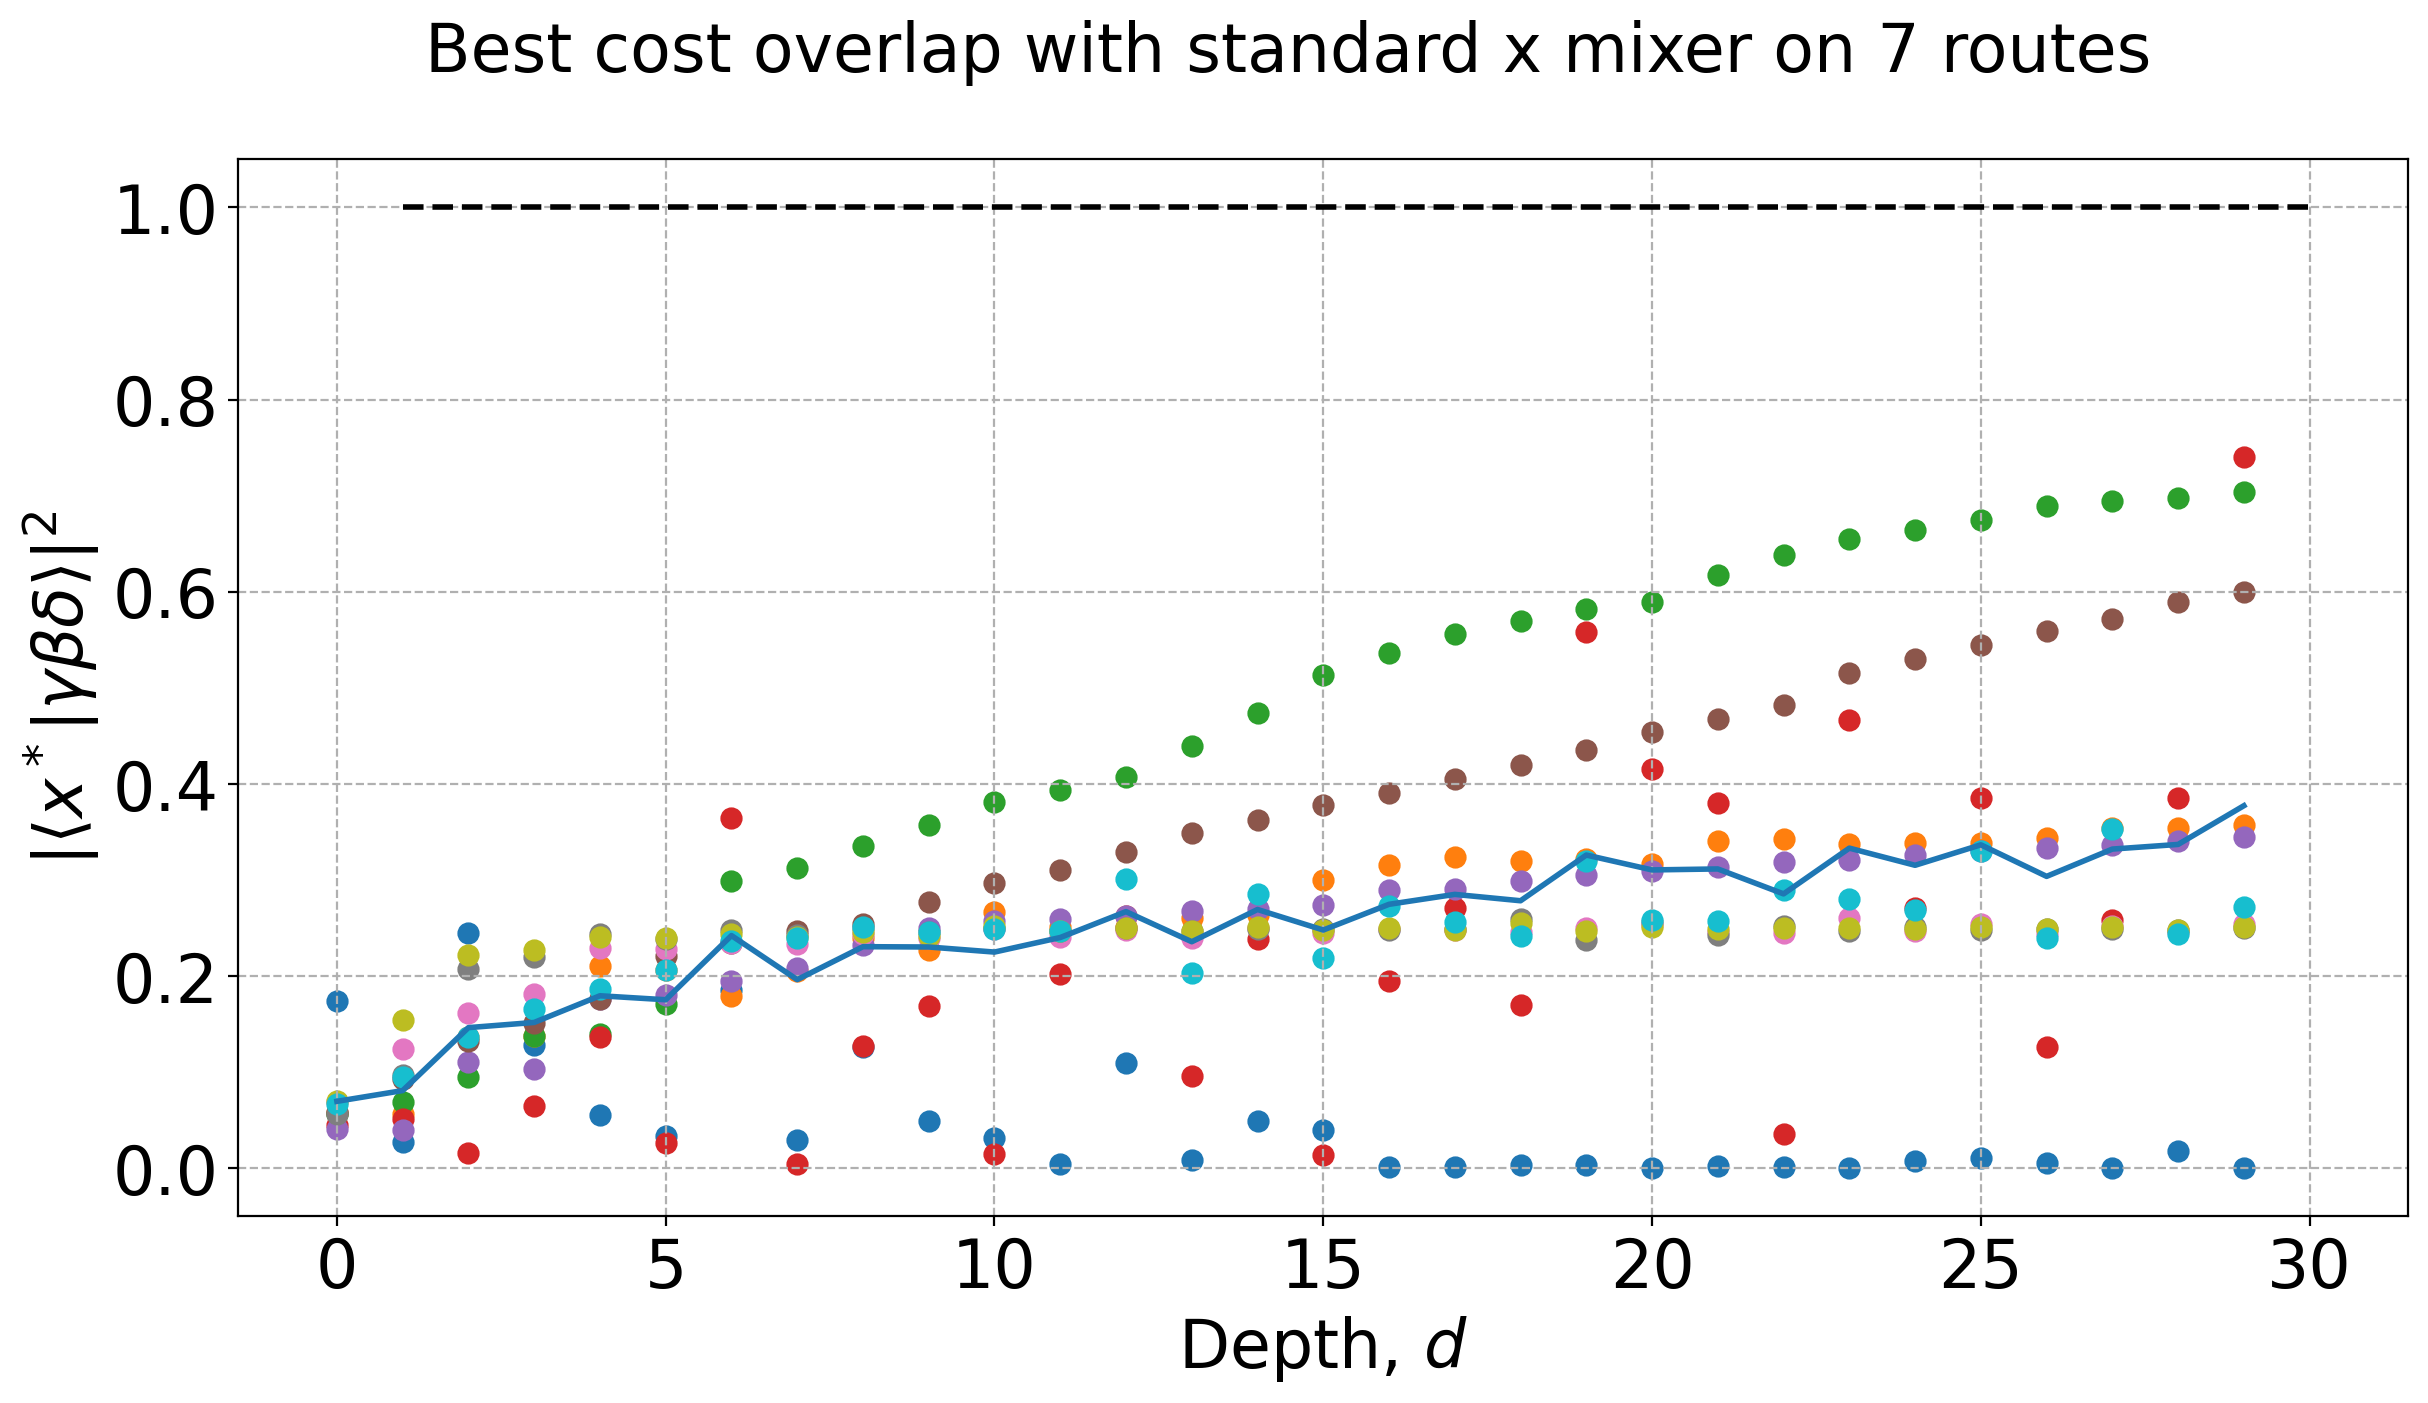

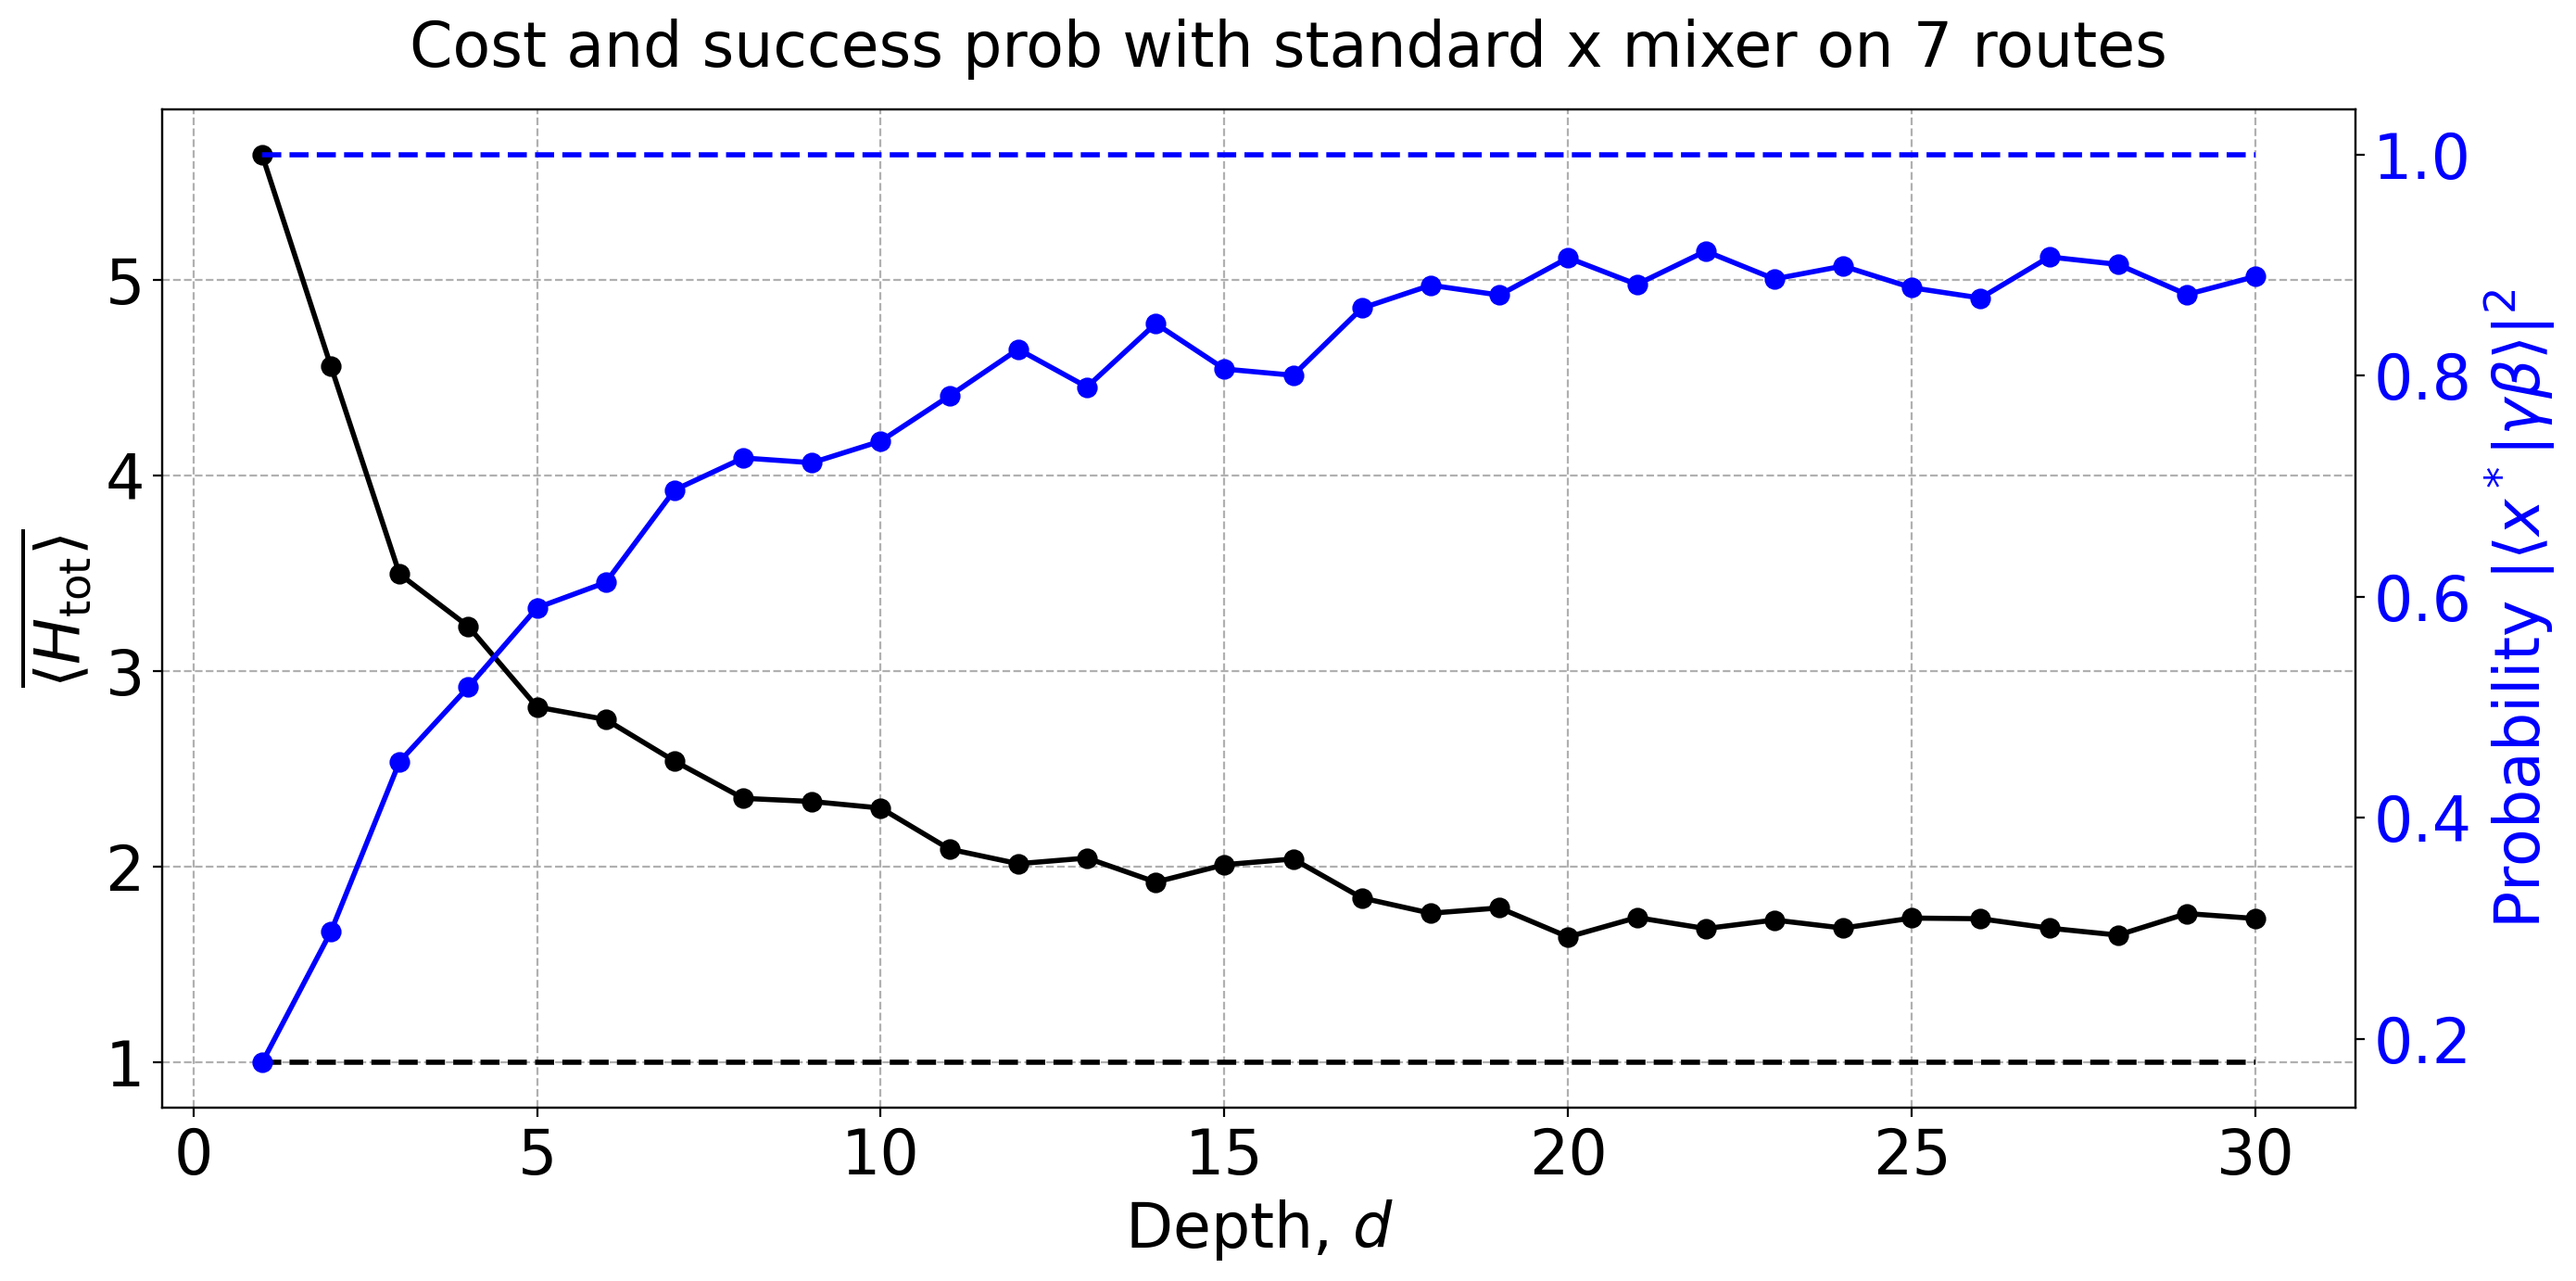

In [22]:
print(np.sum(best_cost_overlap,axis=0)/10)
fig, ax = plt.subplots(figsize  = (14,7))
fig.suptitle(f'Best cost overlap with standard x mixer on {num_routes} routes')
ax.plot(range(best_cost_overlap.shape[1]), np.sum(best_cost_overlap,axis=0)/10)
for i in range(10):
    ax.scatter(range(best_cost_overlap.shape[1]), best_cost_overlap[i])
ax.hlines(1,1,max_depth,color = "black", ls = "--")
ax.grid(ls = "--")
ax.set_ylabel(r"$|{\langle x^* |\gamma \beta \delta \rangle}|^2$", color = "black")
ax.set_xlabel("Depth, $d$")
plt.savefig(f'./data/saved_histograms/Averages/Best cost overlap with standard x mixer on {num_routes} routes high sol.pdf')
plt.show()
plot_SP_C(SP_avg, C_avg, max_depth, title = f'Cost and success prob with standard x mixer on {num_routes} routes', savefig = f'./data/saved_histograms/Averages/Cost and success prob with standard x mixer on {num_routes} routes maxdepth {max_depth}.pdf')

In [12]:
np.save(f'./data/saved_probs_costs/Standard_average_cost_{num_routes}_routes_{max_depth}_depth_high_sol', C_avg)
np.save(f'./data/saved_probs_costs/Standard_average_success_prob_{num_routes}_routes_{max_depth}_depth_high_sol', SP_avg)
np.save(f'./data/saved_probs_costs/Standard_cost_{num_routes}_routes_{max_depth}_depth_high_sol', C)
np.save(f'./data/saved_probs_costs/Standard_success_prob_{num_routes}_routes_{max_depth}_depth_high_sol', SP)
np.save(f'./data/saved_probs_costs/Standard_best_cost_overlap_{num_routes}_routes_{max_depth}_depth_high_sol', best_cost_overlap)